### CPU 환경

In [1]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          64
On-line CPU(s) list:             0-63
Thread(s) per core:              2
Core(s) per socket:              16
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Platinum 8153 CPU @ 2.00GHz
Stepping:                        4
CPU MHz:                         2299.999
CPU max MHz:                     2800.0000
CPU min MHz:                     1000.0000
BogoMIPS:                        4000.00
Virtualization:                  VT-x
L1d cache:                       1 MiB
L1i cache:                       1 MiB
L2 cache:                        32 MiB
L3 cache:                   

### GPU 환경

In [2]:
!nvidia-smi

Wed Feb 17 08:09:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:37:00.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   5232MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

### RAM 용량 확인

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          125Gi        12Gi       2.1Gi        62Mi       110Gi       111Gi
Swap:         8.0Gi        86Mi       7.9Gi


### HDD 용량 확인

In [4]:
# 디스크 용량 확인
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev             63G     0   63G   0% /dev
tmpfs            13G  2.7M   13G   1% /run
/dev/sda2       549G  418G  104G  81% /
tmpfs            63G   20K   63G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs            63G     0   63G   0% /sys/fs/cgroup
/dev/sda1       511M  7.8M  504M   2% /boot/efi
/dev/loop4       56M   56M     0 100% /snap/core18/1944
tmpfs            13G     0   13G   0% /run/user/1000
/dev/loop6       32M   32M     0 100% /snap/snapd/10707
/dev/loop0       70M   70M     0 100% /snap/lxd/19032
/dev/loop1       70M   70M     0 100% /snap/lxd/19188
/dev/sdb2       466G  240G  226G  52% /home/test/mount_folder
/dev/loop5       56M   56M     0 100% /snap/core18/1988
/dev/loop2       32M   32M     0 100% /snap/snapd/11036


In [5]:
### OS 환경

In [6]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="20.04.1 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.1 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


## 패키지 설치

In [7]:
#!pip install numpy

# Pytorch 10.2 GPU install
#!pip install torch

# Pytorch 10.2 CPU install
#!pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

#!pip install torchvision
#!pip install torchinfo
#!pip install tqdm

## 패키지 불러오기

In [8]:
import sys, time, datetime, pytz
import numpy as np

import torch, torchvision
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from Model import UNet

from Dataset import Dataset, Normalization, ToTensor
from Utils import IOU_Numpy, Draw_Image

import torchinfo
from torchinfo import summary

from tqdm import tqdm

## 설치 패키지 확인

In [9]:
print('python version:',sys.version)
print('numpy version:', np.__version__)
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

python version: 3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0]
numpy version: 1.19.2
torch version: 1.7.1
torchvision version: 0.8.2


## 모델 파라미터 (Parameter)

In [10]:
# 모델에 입력할 Input 이미지의 크기를 지정함.
IMG_WIDTH = 512
IMG_HEIGHT = 512

# 각 Input당 결과를 확인하기 위하여 배치 사이즈를 1로 지정함.
batch_size = 1

# 데이터를 읽어올 경로를 지정함.
data_dir = "../Dataset/preprocessed/segmentation/"
# 학습된 모델이 저장된 경로를 지정함.
ckpt_dir = "./Models/"
# 생성된 이미지를 저장하는 경로를 지정함.
save_dir = "./Images_Results/"

# 모델 이름
Model_name = "chicken_segmentation"
# 모델을 연산할 장비 설정 (Docker환경에서 작동할 수 있도록 CPU에서 계산함)
device = torch.device('cpu')

## 데이터 셋 확인

## 데이터 셋 (Dataset) 불러오기

In [11]:
# Test set을 읽어옴
test_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])
test_dataset = Dataset(data_dir=data_dir, train=False, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)
print(f'Test set size: {len(test_dataset)}')

Test set size: 3304


## 모델 확인 (Summary)

In [12]:
temp_model = UNet()
_ = summary(temp_model, (batch_size, 3, IMG_WIDTH, IMG_HEIGHT))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 64, 512, 512]         --
|    └─Conv2d: 2-1                       [1, 64, 512, 512]         1,792
|    └─BatchNorm2d: 2-2                  [1, 64, 512, 512]         128
|    └─ReLU: 2-3                         [1, 64, 512, 512]         --
├─Sequential: 1-2                        [1, 64, 512, 512]         --
|    └─Conv2d: 2-4                       [1, 64, 512, 512]         36,928
|    └─BatchNorm2d: 2-5                  [1, 64, 512, 512]         128
|    └─ReLU: 2-6                         [1, 64, 512, 512]         --
├─MaxPool2d: 1-3                         [1, 64, 256, 256]         --
├─Sequential: 1-4                        [1, 128, 256, 256]        --
|    └─Conv2d: 2-7                       [1, 128, 256, 256]        73,856
|    └─BatchNorm2d: 2-8                  [1, 128, 256, 256]        256
|    └─ReLU: 2-9                         [1, 128, 256, 256]        --
├

## 테스트 (Test) 수행

In [13]:
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

### 모델 불러오기 (Load)

In [14]:
# 모델의 구조를 불러옴.
eval_net = UNet().to(device) # device : cpu
# 학습된 가중치를 읽어옴.
state_dict = torch.load(ckpt_dir + Model_name + ".pkl", map_location=device)
## nn.DataParallel을 통해 학습을 시켰다면, 모델에 자동적으로 module.를 붙이게 된다
# 따라서 다음의 코드를 통해 module.를 제거함.
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
## nn.DataParallel을 통해 학습을 시켰다면 new_state_dict, 아니면 state_dict를 불러올 것
eval_net.load_state_dict(new_state_dict)

<All keys matched successfully>

### 테스트 이미지 평가 (Predict)

In [15]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 시작 시간 : {nowDatetime}')

테스트 시작 시간 : 2021-02-17 17:09:35


In [16]:
since=time.time()

In [17]:
with torch.no_grad():  # test 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
    eval_net.eval()  # 네트워크를 evaluation 용으로 선언
    test_iou_arr = []
    
    for data in tqdm(test_loader):
        # forward
        label = data['label'].to(device)
        inputs = data['input'].to(device)
        output = eval_net(inputs)

        # loss
        test_iou_arr += [IOU_Numpy(fn_classifier(output), label)]
    
    test_iou_np = np.array(test_iou_arr)
    
    print("threshold (0.5): mean %.4f | std %.4f, | max %.4f, | min %.4f" % (np.mean(test_iou_np), np.std(test_iou_np), np.max(test_iou_np), np.min(test_iou_np)))  

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

100%|██████████| 3304/3304 [1:22:35<00:00,  1.50s/it]

threshold (0.5): mean 0.9139 | std 0.0330, | max 0.9690, | min 0.7038


In [18]:
end=time.time()
print(f'테스트 소요 시간: {int((end-since)//60)}m {int((end-since)%60)}s')

테스트 소요 시간: 82m 35s


In [19]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
nowDatetime = now.strftime('%Y-%m-%d %H:%M:%S')
print(f'테스트 종료 시간 : {nowDatetime}')

테스트 종료 시간 : 2021-02-17 18:32:12


## 시각화 (VIsualization)

../Dataset/preprocessed/segmentation/test/img/_174626_frame_7192_1.npy


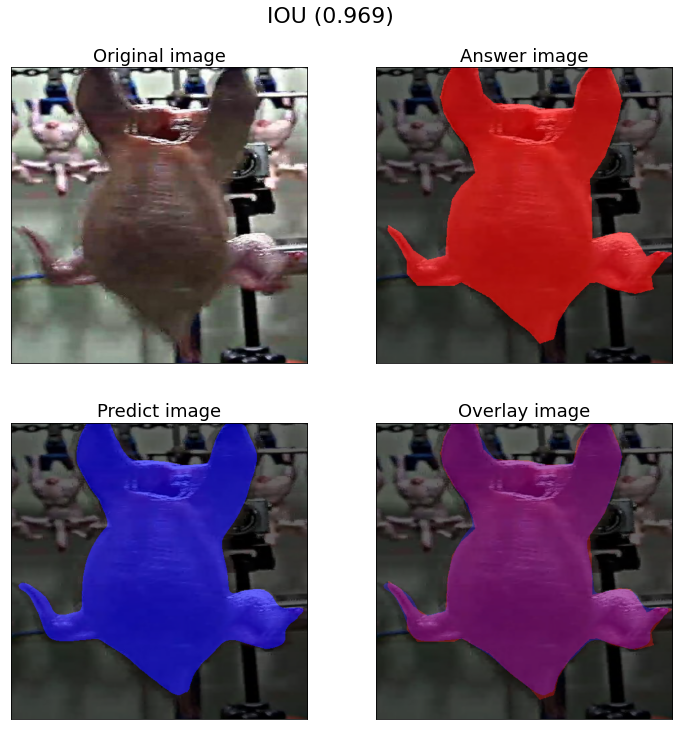

In [20]:
# IOU가 가장 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=0, device=device)

../Dataset/preprocessed/segmentation/test/img/_170658_frame_5284_1.npy


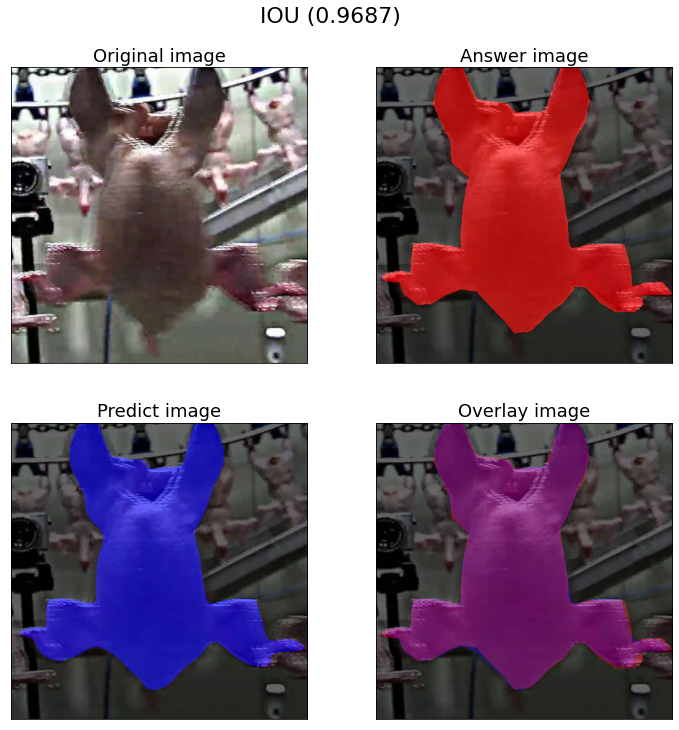

In [21]:
# IOU가 두번째로 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=1, device=device)

../Dataset/preprocessed/segmentation/test/img/_173354_frame_6571_0.npy


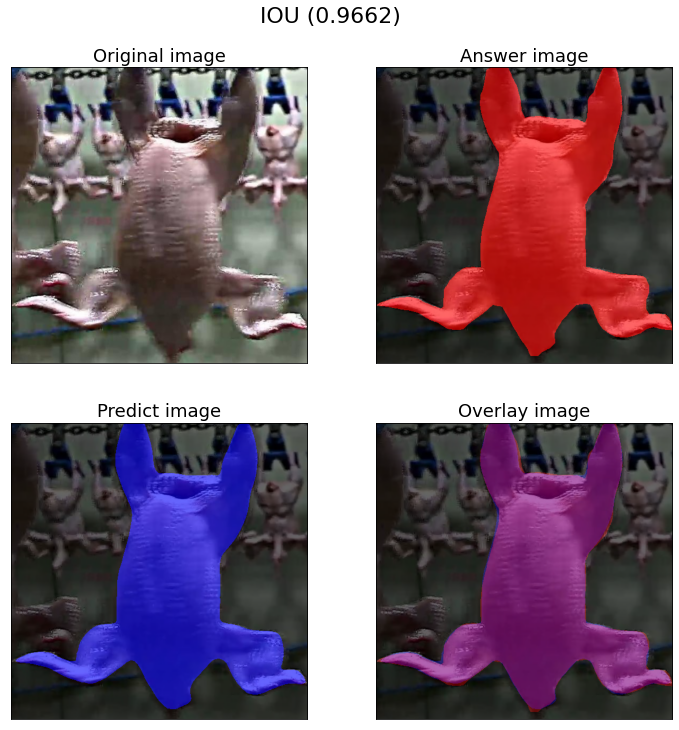

In [22]:
# IOU가 세번째로 좋은 결과
Draw_Image(eval_net, test_dataset, test_iou_np, save_dir, Model_name, idx=2, device=device)